In [1]:
%%capture
!pip install mne
!pip install braindecode
!pip install mne_bids

In [2]:
%%capture

from braindecode.datautil import create_from_mne_epochs
from braindecode.datasets import WindowsDataset, BaseConcatDataset
import mne
import numpy as np
import pandas as pd

# Load participant data
participants_data = pd.read_csv('../participants.tsv', delimiter='\t')
subject_ids = range(1, 112)

# Load EEG data and labels
fnames = [f"../derivatives/sub-{subject_id:03d}/ses-t1/eeg/sub-{subject_id:03d}_ses-t1_task-resteyesc_proc-clean_epo.fif" for subject_id in subject_ids]
ages = [participants_data.loc[participants_data['participant_id'] == f"sub-{subject_id:03d}", 'age'].values[0] for subject_id in subject_ids]

# Load the epochs and create datasets
datasets = []
window_size_samples = 1000
window_stride_samples = 1000
drop_last_window = False

for fname, age in zip(fnames, ages):
    epochs = mne.read_epochs(fname)

    # Create a dataset from each epoch
    ds = create_from_mne_epochs(
        [epochs],
        window_size_samples=window_size_samples,
        window_stride_samples=window_stride_samples,
        drop_last_window=drop_last_window,
    )
    # Store the age with the dataset
    ds.target = np.array([age])
    datasets.append(ds)

# Concatenate all the datasets
dataset = BaseConcatDataset(datasets)

In [3]:
%%capture
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from deep_learning_utils import create_model, create_estimator

# Number of channels in the raw data
n_channels = epochs.info['nchan']

# Define the number of folds
n_folds = 5

# Initialize the k-fold cross-validation class
kf = KFold(n_splits=n_folds)

# Initialize lists to store the training loss and negative MAE for each fold
all_loss_values = []
all_neg_mae_values = []

# Convert ages to numpy array and--- add extra dimension
ages = np.array(ages)[:, None]

# Perform k-fold cross-validation
for fold, (train_indices, test_indices) in enumerate(kf.split(datasets)):

    # Split the dataset into training and test datasets
    train_dataset = BaseConcatDataset([datasets[i] for i in train_indices])
    test_dataset = BaseConcatDataset([datasets[i] for i in test_indices])

    # Get the corresponding ages for the training and test datasets
    train_ages = ages[train_indices]
    test_ages = ages[test_indices]

    # Create the model
    model, lr, weight_decay = create_model('deep', window_size_samples, n_channels, cropped=False, seed=42)

    # Create the estimator
    regressor = create_estimator(model=model, n_epochs=20, batch_size=32, lr=lr, weight_decay=weight_decay, n_jobs=-1)

    # Fit the model on the training data
    regressor.fit(train_dataset, y=train_ages)

    # Extract the history from the model
    history = regressor.history

    # Extract the training loss and negative mean absolute error values
    loss_values = [entry['train_loss'] for entry in history]
    neg_mae_values = [entry['neg_mean_absolute_error'] for entry in history]

    # Append the loss values and negative MAE values to the lists
    all_loss_values.append(loss_values)
    all_neg_mae_values.append(neg_mae_values)

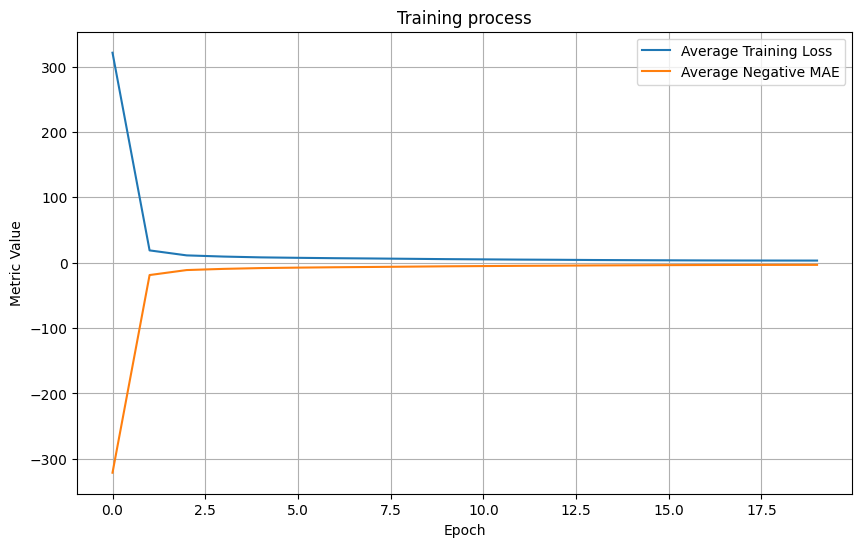

In [7]:
import matplotlib.pyplot as plt

# Average the loss values and negative MAE values across all folds
avg_loss_values = np.mean(all_loss_values, axis=0)
avg_neg_mae_values = np.mean(all_neg_mae_values, axis=0)

# Plot the average loss values and negative MAE values
plt.figure(figsize=(10, 6))
plt.plot(avg_loss_values, label='Average Training Loss')
plt.plot(avg_neg_mae_values, label='Average Negative MAE')
plt.title('Training process')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
np.mean(all_loss_values, axis=0)

array([321.24921636,  18.86073489,  11.22505361,   9.40542923,
         8.18415683,   7.5034998 ,   6.91942925,   6.48584448,
         5.98776587,   5.48914804,   5.12342416,   4.76189905,
         4.50488674,   4.14005336,   3.90634942,   3.68363947,
         3.51162539,   3.39739157,   3.32209207,   3.28320729])

In [6]:
np.mean(all_neg_mae_values, axis=0)

array([-321.24921668,  -18.86073489,  -11.22505361,   -9.40542923,
         -8.18415683,   -7.5034998 ,   -6.91942925,   -6.48584448,
         -5.98776587,   -5.48914804,   -5.12342416,   -4.76189905,
         -4.50488674,   -4.14005336,   -3.90634942,   -3.68363947,
         -3.51162539,   -3.39739157,   -3.32209207,   -3.28320729])